## Objective:
- Reduce financial lost by identifying fraudulent transactions
- Develop a model to classify fraud; explain the pros and cons of false positives vs. false negatives
- Explain the workings of the model (from a user perspective)
    - Identify the factors used to make the predictions
- Suggest some future actions to reduce fraud.

In [1]:
# Import pandas and numpy
import numpy as np
import pandas as pd

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Import stats from scipy
from scipy import stats

# Import RandomForestClassifer
from sklearn.ensemble import RandomForestClassifier

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Import train_test_split
from sklearn.model_selection import train_test_split

# Import roc_auc_score, roc_curve, and auc
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
# Load in the raw fraud data
fraud_df = pd.read_csv('Fraud_Data.csv')

# load in the raw IP address data
ip_df = pd.read_csv('IpAddress_to_Country.csv')

Before merging the two datasets to provide each user with a country, I need to make sure the data is as expected.

In [3]:
# View the data info
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [4]:
# Identify the numerical variables
NUMERICAL = ['purchase_value', 'age']

# Identify the time variables
TIME = ['signup_time', 'purchase_time']

# Identify the categorical variable
CATEGORICAL = [col for col in fraud_df.columns if col not in NUMERICAL]

# Remove the time variables from the categorical list
CATEGORICAL.remove('signup_time')
CATEGORICAL.remove('purchase_time')

In [5]:
# Retrieve the summary statistics for the numerical variables
fraud_df[NUMERICAL].describe()

,purchase_value,age
count,151112.000000,151112.000000
mean,36.935372,33.140704
std,18.322762,8.617733
min,9.000000,18.000000
25%,22.000000,27.000000
50%,35.000000,33.000000
75%,49.000000,39.000000
max,154.000000,76.000000


In [6]:
# Determine the number of unique values in each cateogrical variable of the fraud data
fraud_df[CATEGORICAL].nunique()

user_id       151112
device_id     137956
source             3
browser            5
sex                2
ip_address    143512
class              2
dtype: int64

User ID is a unique variable within the dataframe (user_id.nunique() = len(fraud_df). I can use it as an index to increase performance. There also appears to be many unique device ids and ip_addresses. I'll take a look at the other 4 categorical variables to  make sure their values make sense.

In [7]:
# Print the unique values in the categorical variables.
for col in ['source', 'browser', 'sex', 'class']:
    print(fraud_df[col].unique())

['SEO' 'Ads' 'Direct']
['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']
['M' 'F']
[0 1]


In [8]:
# Take a look at the ip address data
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [9]:
# Show the number of nunique values
ip_df.nunique()

lower_bound_ip_address    138846
upper_bound_ip_address    138846
country                      235
dtype: int64

It appears that there are only 235 unique countries despite the 138,000 unique upper and lower bound ip addresses. 

First, I will try to group them by countries, returning the minimum lower bound and maximum upper bound. This method assumes that each country uses a distinct range of ip addresses, and no countries have overlapping ranges.

In [10]:
# Group the data by countries
ip_df.groupby('country').agg({'lower_bound_ip_address':min, 'upper_bound_ip_address':max}).sort_values('lower_bound_ip_address',
                                                                                                      axis=0).head(10)

,lower_bound_ip_address,upper_bound_ip_address
country,,
Australia,16777216.0,3758096383
China,16777472.0,3758095871
Japan,16781312.0,3755999231
Thailand,16809984.0,3754950655
India,17170432.0,3758094335
Malaysia,17367040.0,3743186943
Korea Republic of,17498112.0,3758088191
Hong Kong,18874368.0,3758093311
Taiwan; Republic of China (ROC),19005440.0,3754491903


It appears that countries do NOT have distinct ip address ranges. As a result, the group by attempt fails.

Next, I will try a cross join (very computationally and memory intensive) and filter out the results from there.

In [11]:
# # Add a key column on both datasets to perform a cross-join
# fraud_df['key'] = 1
# ip_df['key'] = 1

# # Merge on the key column
# fraud_df.merge(right=ip_df, how='left', on='key')

It was too memory intensive to work. 

Another approach to try is to  iterate through every row in the fraud dataset and filter the ip_address accordingly. This approach is much slower (since I will have to iterate through most of the ip address dataframe until there is a match for every single row). However, I do not need to merge the two dataframes. (Memory efficient, time inefficient).

Before I attempt this, I need to make sure all user ip address fall within at least one range (higher than the minimum lower bound and lower than the higher upper bound).

In [12]:
# Define the max upper bound
upper_bound = ip_df['upper_bound_ip_address'].max()

# Define the minimum lower bound
lower_bound = ip_df['upper_bound_ip_address'].min()

print (lower_bound, upper_bound)

16777471 3758096383


In [13]:
# Make sure all ip_addresses are below the maximum upper bound
print (fraud_df[fraud_df['ip_address'] >= upper_bound].shape)

# Make sure all ip_addresses are above the minimum lower bound
print(fraud_df[fraud_df['ip_address'] <= lower_bound].shape)

(19383, 11)
(634, 11)


It looks like I have run into the first major issue to this dataset. There are entries with ip addresses outside of the complete range of ip addresses. For these entries, it would be most appropriate to fill them in with "Unknown".

### Note:
The following code is the code necessary for transforming the dataframe (merging the two datasets). It is commented out since the resulting dataset has been written into another csv file and reloaded into the notebook to quicken the startup process.

In [14]:
# # Create an empty list to contain the corresponding countries
# country_list = []

# # Create a copy of the fraud dataframe
# fraud_copy = fraud_df.copy()

# # Iterate over the values in the ip addresses
# for row in fraud_df['ip_address']:
#     # Assign the filtered result to a variable
#     country = ip_df.loc[(row >= ip_df['lower_bound_ip_address']) & 
#               (row <= ip_df['upper_bound_ip_address']), 'country'].tolist()
#     # If there is a corresponding country, append it to the list
#     if len(country) == 1:
#         country_list.extend(country)
#     # If there are two possible countries, raise an error
#     elif len(country) > 1:
#         raise NameError('More than one possible country')
#     # Else, append a null value
#     else:
#         country_list.append(np.nan)

# # Assign a new column to the datafrmae
# fraud_copy['country'] = country_list

# # Fill in the null values with "Unknown"
# fraud_copy.fillna('Unknown', inplace=True)

In [15]:
# Needs to be benchmarked against the code above.

# # Create an empty list to contain the corresponding countries
# country_list = []

# # Iterate over the fraud dataframe using iterrows
# for index, row in fraud_df.iterrows():
#     # Assign the filtered result to a variable
#     country = ip_df.loc[(row['ip_address'] >= ip_df['lower_bound_ip_address']) & 
#               (row['ip_address'] <= ip_df['upper_bound_ip_address']), 'country'].tolist()
#     # If there is a corresponding country, append it to the list
#     if len(country) == 1:
#         country_list.extend(country)
#     # If there are two possible countries, raise an error
#     elif len(country) > 1:
#         raise NameError('More than one possible country')    
#     # Else, append a null value
#     else:
#         country_list.append(np.nan)

# # Assign a new column to the datafrmae
# fraud_df['country'] = country_list

In [16]:
# # Determine the occurrence of the null entries.
# fraud_df[fraud_df['country'].isnull()].shape

Since my method was computationally slow, I will try proposed attempt on stackoverflow. 

https://stackoverflow.com/questions/46525786/how-to-join-two-dataframes-for-which-column-values-are-within-a-certain-range

In [17]:
# ip_df.index = pd.IntervalIndex.from_arrays(ip_df['lower_bound_ip_address'],ip_df['upper_bound_ip_address'],closed='both')

# # event = ip_df.loc[ip_df.index.get_indexer(df['ip_address']), 'country']

# df['country'] = df['ip_address'].apply(lambda x : ip_df.iloc[ip_df.index.get_loc(x)]['country'])

Unfortunately, the method does not work due to the values outside of the given range of ip addresses.

Next, I will try another method using the pandasql package.

https://stackoverflow.com/questions/30627968/merge-pandas-dataframes-where-one-value-is-between-two-others

In [18]:
# # Import the pandasql package
# import pandasql as ps

# # Write the SQL query
# sqlcode = '''
# SELECT *
# FROM fraud_df
# LEFT JOIN ip_df
# ON fraud_df.ip_address BETWEEN ip_df.lower_bound_ip_address AND ip_df.upper_bound_ip_address
# '''

# # Execute the sql query to derive the desired dataframe
# merged_df = ps.sqldf(sqlcode, locals())

The method appears to be too computationally intensive, more so than the previous method. It takes too long to run (20 minutes and no result). From the same link, I will try using sqlite3 instead.

In [19]:
# # Attempt the above process using sqlite3

# # Import sqlite3
# import sqlite3

# # Make the database
# conn = sqlite3.connect(':memory:')

# # Create the tables
# fraud_df.to_sql('fraud', conn, index=False)
# ip_df.to_sql('ip', conn, index=False)

# # Write the SQL query
# sqlcode = '''
# SELECT *
# FROM fraud
# LEFT JOIN ip
# ON fraud.ip_address BETWEEN ip.lower_bound_ip_address AND ip.upper_bound_ip_address
# '''

# merged_df = pd.read_sql_query(sqlcode, conn)

Likewise, this method is too computational intensive. Similar results as the prior attempt with pandasql.

### Break:
Since I can not currently determine a more efficient method to merge these two datasets, I will write the transformed dataset into a working csv file. This will allow me to skip the transformation steps in the future.

In [20]:
# # Make sure no rows were lost
# assert len(fraud_copy) == len(fraud_df)

In [21]:
# # Write the dataset into another csv file 
# fraud_copy.to_csv('transformed_fraud.csv')

### Analytics and Inferential Statistics
At this point, I will load the working dataset back into the notebook. I will focus on drawing insights and creating visualizations that will address the objective at hand. The problem being addressed here is a imbalanced classification problem. 

First let's perform some feature engineering, particularly on the date columns.

In [22]:
# Load in the transformed fraud dataset
comp_fraud = pd.read_csv('transformed_fraud.csv', index_col=0)

In [23]:
# Make sure no rows were lost in the ETL process
assert len(comp_fraud) == len(fraud_df)

# Make sure no columns were lost
assert len(comp_fraud.columns) - 1 == len(fraud_df.columns) 

In [24]:
# Convert the signup_time and purchase_time dtypes to datetime objects
for col in ['signup_time', 'purchase_time']:
    comp_fraud[col] = pd.to_datetime(comp_fraud[col])

In [25]:
# Print the range of for signup times
print ('First Signup: {}'.format(comp_fraud['signup_time'].min()))
print ('Last Signup: {}'.format(comp_fraud['signup_time'].max()))

First Signup: 2015-01-01 00:00:42
Last Signup: 2015-08-18 04:40:29


In [26]:
# Print the range of for purchase times
print ('First Purchase: {}'.format(comp_fraud['purchase_time'].min()))
print ('Last Purchase: {}'.format(comp_fraud['purchase_time'].max()))

First Purchase: 2015-01-01 00:00:44
Last Purchase: 2015-12-16 02:56:05


It appears that the dataset is confined within year 2015. As a result, I will derive 3 variables for each time variables (dayofweek, weekofyear, and month). Additionally, I will calculate the time difference between signup and purchase times.

In [27]:
# Define the three variables for signup
comp_fraud['signup_month'] = comp_fraud['signup_time'].dt.month
comp_fraud['signup_week'] = comp_fraud['signup_time'].dt.weekofyear
comp_fraud['signup_day'] = comp_fraud['signup_time'].dt.weekday

# Define the three variables for purchase
comp_fraud['purchase_month'] = comp_fraud['purchase_time'].dt.month
comp_fraud['purchase_week'] = comp_fraud['purchase_time'].dt.weekofyear
comp_fraud['purchase_day'] = comp_fraud['purchase_time'].dt.weekday

# Define the time difference between signup and purchase
comp_fraud['purchase_to_signup'] = (comp_fraud['purchase_time'] - comp_fraud['signup_time']).dt.days

In [28]:
# Define the time variables (these will be categorical variables)
TIME = ['signup_month', 'signup_week', 'signup_day',
       'purchase_month', 'purchase_week', 'purchase_day']

# Append the purchase_to_signup to the list of numerical columns
NUMERICAL.append('purchase_to_signup')

Next, I will use inferential statistics to determine which variables contribute to identifying fraudulent activity. I will use two-sided t-tests for numerical variables and chi-squared tests for categorical variables (p-value < 0.05).

In [29]:
# Define the target and non-target dataframes
fraud = comp_fraud[comp_fraud['class'] == 1].copy()
non_fraud = comp_fraud[comp_fraud['class'] == 0].copy()

print ('Fraudulent Activity occurs at a rate of {:.2f}%'. format(np.mean(comp_fraud['class']) * 100))

Fraudulent Activity occurs at a rate of 9.36%


In [30]:
# Perform the two-sided t-test
for col in NUMERICAL:
    t_score = stats.ttest_ind(non_fraud[col], fraud[col])
    print ('T-score for {}: {}'. format(col, t_score))

T-score for purchase_value: Ttest_indResult(statistic=-0.39301852199253456, pvalue=0.6943063557452367)
T-score for age: Ttest_indResult(statistic=-2.574828503654144, pvalue=0.010029922325055042)
T-score for purchase_to_signup: Ttest_indResult(statistic=102.95656815888924, pvalue=0.0)


In [31]:
# Define a function for bootstrapping
def bootstrap(cat, num):
    '''Returns [num] bootstrap means of specified category'''
    # Create [num] instances of empty arrays for low_train, high_train to contain the bootstrap samples
    non_fraud_bootstrap = np.empty(num)
    fraud_bootstrap = np.empty(num)

    for i in range(num):
        # Define the bootstrap samples and store them in the empty arrays 
        non_fraud_bootstrap[i] = np.mean(np.random.choice(non_fraud[cat], len(non_fraud)))
        fraud_bootstrap[i] = np.mean(np.random.choice(fraud[cat], len(fraud)))
        
    return non_fraud_bootstrap, fraud_bootstrap


purchase_value:
95% Confidence Interval for non-Fraudulent Activity: [36.83390162 37.01754259]
95% Confidence interval for Fraudulent Activity: [36.70089216 37.28268674]


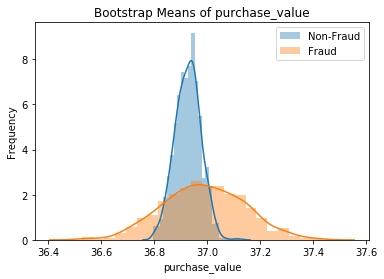


age:
95% Confidence Interval for non-Fraudulent Activity: [33.07451519 33.16742449]
95% Confidence interval for Fraudulent Activity: [33.17615363 33.46080842]


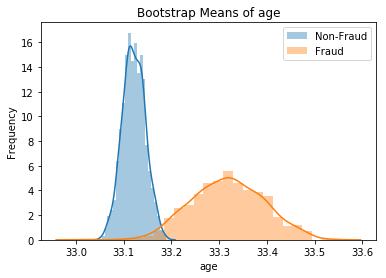


purchase_to_signup:
95% Confidence Interval for non-Fraudulent Activity: [59.4085267  59.77025376]
95% Confidence interval for Fraudulent Activity: [27.17625433 28.44712388]


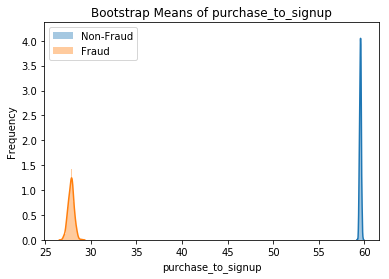

In [32]:
# Iterate over the values in the NUMERICAL list
for col in NUMERICAL:
    
    # Define 100 bootstrap samples for each category
    non_fraud_repl, fraud_repl = bootstrap(col, 1000)
    
    # Define the confidence intervals
    confidence_interval_non_fraud = np.percentile(non_fraud_repl, [2.5, 97.5])
    confidence_interval_fraud = np.percentile(fraud_repl, [2.5, 97.5])
    
    # Print the results
    print ('\n{}:'.format(col))
    print ('95% Confidence Interval for non-Fraudulent Activity:', confidence_interval_non_fraud)
    print ('95% Confidence interval for Fraudulent Activity:', confidence_interval_fraud)
    
    # Plot the samples
    sns.distplot(non_fraud_repl, label='Non-Fraud')
    sns.distplot(fraud_repl, label='Fraud')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Bootstrap Means of {}'.format(col))
    plt.legend()
    plt.show()

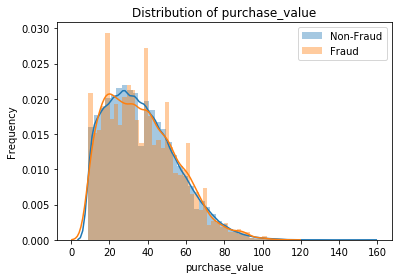

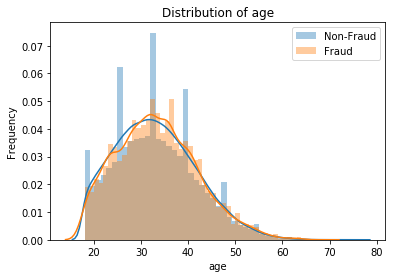

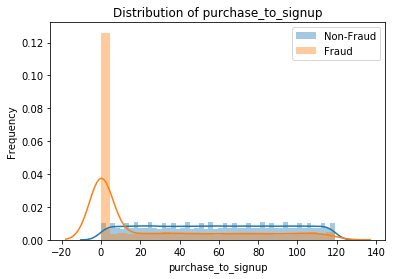

In [33]:
# Also provide the regular distribution

# Iterate over the values in the NUMERICAL list
for col in NUMERICAL:
    # Plot the samples
    sns.distplot(non_fraud[col], label='Non-Fraud')
    sns.distplot(fraud[col], label='Fraud')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))
    plt.legend()
    plt.show()

Text(0.5,1,'Non-Fraudulent Activity')

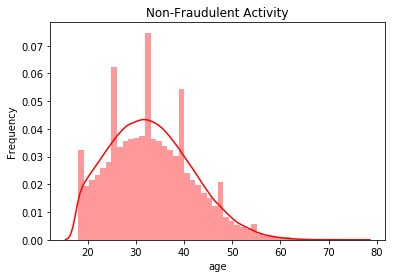

In [34]:
sns.distplot(non_fraud['age'], kde=True, color='red')
plt.ylabel('Frequency')
plt.title('Non-Fraudulent Activity')

Text(0.5,1,'Fraudulent Activity')

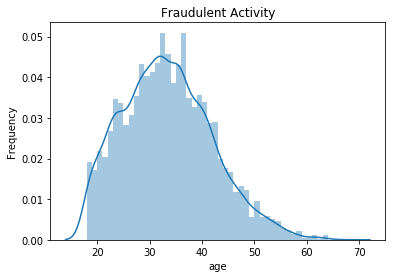

In [35]:
sns.distplot(fraud['age'], kde=True)
plt.ylabel('Frequency')
plt.title('Fraudulent Activity')

Notes:
-  It appears that purchase value is not a high-impact variable to identifying fraudulent activity. 
- However, it appears that age is, where fraudulent entries have a higher frequency of between ages 31-35. Additionally, it has a smaller range for ages.
- Most fraudulent activity occurs when the purchase is made within 24 hours of the signup time.

In [36]:
CATEGORICAL

['user_id', 'device_id', 'source', 'browser', 'sex', 'ip_address', 'class']

In [37]:
comp_fraud.nunique()

user_id               151112
signup_time           151112
purchase_time         150679
purchase_value           122
device_id             137956
source                     3
browser                    5
sex                        2
age                       58
ip_address            143512
class                      2
country                  182
signup_month               8
signup_week               34
signup_day                 7
purchase_month            12
purchase_week             51
purchase_day               7
purchase_to_signup       120
dtype: int64

In [38]:
# Apply chi-squared tests to the categorical columns
for col in ['source', 'browser', 'sex', 'country']:
    cont_table = pd.crosstab(comp_fraud['class'], comp_fraud[col])
    score, p_value, dof, array = stats.chi2_contingency(cont_table)
    print ('X-squared for {}: X-Score:{}    p-value:{}'.format(col, score, p_value))

X-squared for source: X-Score:64.92317707262569    p-value:7.981990836440143e-15
X-squared for browser: X-Score:44.556571734650184    p-value:4.916028350364759e-09
X-squared for sex: X-Score:8.76381632004166    p-value:0.003072654263243465
X-squared for country: X-Score:864.7936698678808    p-value:1.0717772484165735e-89


In [39]:
# Apply chi-squared tests to the time columns
for col in TIME:
    cont_table = pd.crosstab(comp_fraud['class'], comp_fraud[col])
    score, p_value, dof, array = stats.chi2_contingency(cont_table)
    print ('X-squared for {}: X-Score:{}    p-value:{}'.format(col, score, p_value))

X-squared for signup_month: X-Score:18934.195905642006    p-value:0.0
X-squared for signup_week: X-Score:33877.442965507216    p-value:0.0
X-squared for signup_day: X-Score:167.73064169626298    p-value:1.362212147053633e-33
X-squared for purchase_month: X-Score:57439.84093652166    p-value:0.0
X-squared for purchase_week: X-Score:70898.20523105397    p-value:0.0
X-squared for purchase_day: X-Score:149.8269290303558    p-value:8.417414694341885e-30


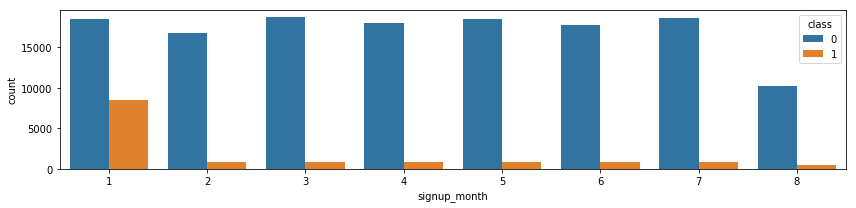

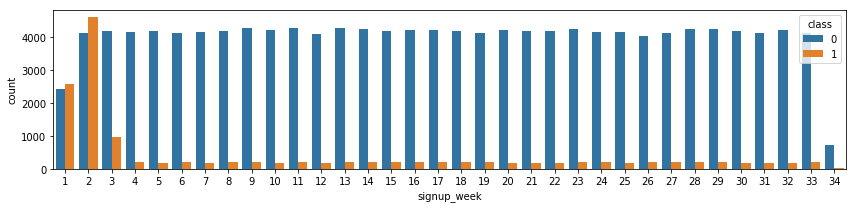

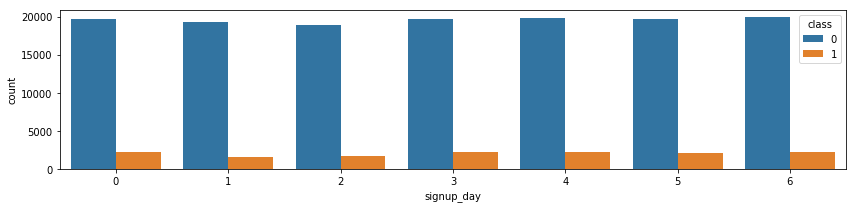

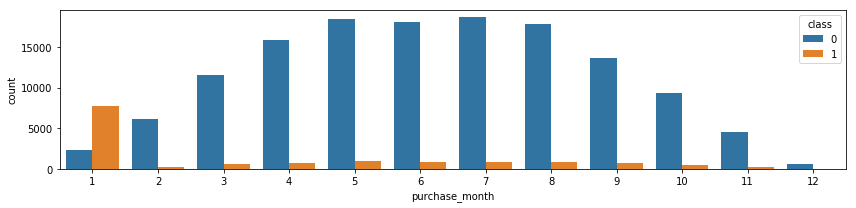

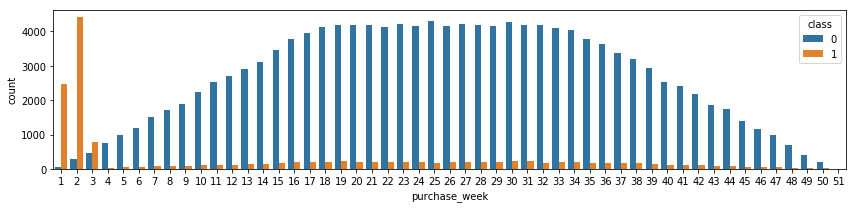

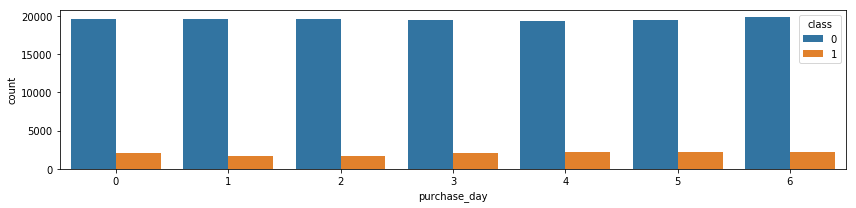

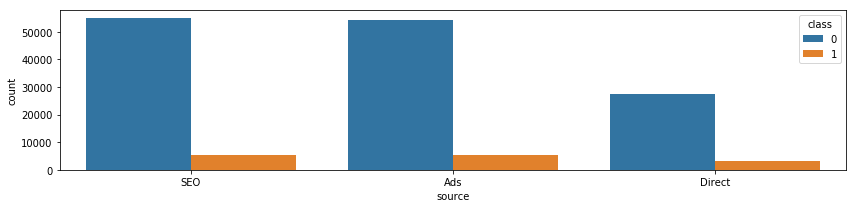

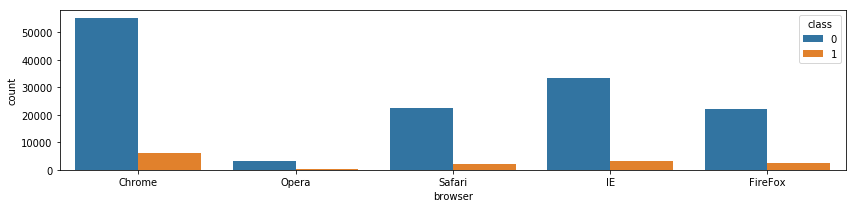

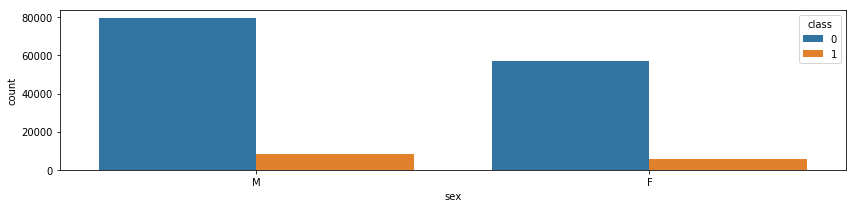

In [40]:
# Define a new categorical list w/o the country
CATEGORICAL = TIME + ['source', 'browser', 'sex']

for col in CATEGORICAL:
    plt.figure(figsize=(12,3))
    sns.countplot(x=col, hue='class', data=comp_fraud)
    plt.tight_layout()

Notes:
- It appears that most fraudulent activity occurs during January (first 3 weeks of the year). In this case, I will keep the weekofyear information, scrapping the day of year and month categories.
- SEO and Ads appear to have more entries for fraudulent activities.
- Chrome has the most fraud activity

Let's take a closer look at these insights, then proceed to working with countries.

In [41]:
# Show the first 5 weeks for signup week
comp_fraud.groupby('signup_week').agg({'class':'mean'}).head()

,class
signup_week,
1,0.514691
2,0.527185
3,0.185135
4,0.048446
5,0.043399


In [42]:
# Show the first 5 weeks for purchase week
comp_fraud.groupby('purchase_week').agg({'class':'mean'}).head()

,class
purchase_week,
1,0.982428
2,0.940825
3,0.621708
4,0.041667
5,0.050000


In [43]:
# Show the fraud rate for source
comp_fraud.groupby('source').agg({'class':'mean'})

,class
source,
Ads,0.092066
Direct,0.105370
SEO,0.089285


In [44]:
# Show the fraud rate for browser
comp_fraud.groupby('browser').agg({'class':'mean'})

,class
browser,
Chrome,0.098792
FireFox,0.095165
IE,0.086775
Opera,0.089227
Safari,0.090201


In [45]:
# Show the fraud rate for sex
comp_fraud.groupby('sex').agg({'class':'mean'})

,class
sex,
F,0.091007
M,0.095523


In [46]:
# Show the fraud rate for country
country_df = comp_fraud.groupby('country').agg({'class':'mean'}).sort_values('class', ascending=False)

# Count all the countries with fraud rates > 10%
country_df[country_df['class'] > 0.1].shape

(44, 1)

In [47]:
# Show the 5 most common countries
comp_fraud['country'].value_counts()[:5]

United States     58049
Unknown           21966
China             12038
Japan              7306
United Kingdom     4490
Name: country, dtype: int64

In [48]:
# Create a list with 5 of the most common countries
COUNTRY = comp_fraud['country'].value_counts()[:5].index

country_df.loc[COUNTRY]

,class
United States,0.095626
Unknown,0.085723
China,0.086642
Japan,0.097865
United Kingdom,0.106236


### Summary:
- Approximately 50% of users that sign up in the first two weeks of the year are frauds, with 18% in the third week.
- 95% of users that make a purchase in the first two weeks of the year are fraud entries, with 62% in the third week.
- Chrome and Firefox have the highest fraud rates.
- Most activity is within the United States. The top 5 countries have fraud rates between 8.5% - 10.6%.

### Building the model
For the model, the most optimal accuracy would be to minimize the false positive and false negatives as much as possible. A false positive represents real activity classified as fraud, whereas a false negative represents fraud classified as real activity. In both cases, there are financial consequences, both with varying magnitude depending on the perspective.

For this model, I will use RandomForestClassifier to classify fraudulent activity. My reason for doing so is that it uses a subset of data (both total entries and total variables) in each of its single decision trees and later combines them. This helps address any numerical outliers, and attaches weights to each variables. Computationally, it's also better than most ensemble methods.

In [49]:
device_group = comp_fraud.groupby('device_id').agg({'class':'mean'})
print(len(device_group[(device_group['class'] < 1.0) & device_group['class'] > 0.0]))
print (len(device_group))

2685
137956


Of ~138,000 unique devices, ~2,700 devices (approximaely 2%) have both fraudulent and real activity. Additionally, most devices have a single entry each so the device id itself doesn't provide too much relevant information. As a result, I will exclude it from my columns of interest.

In [50]:
# Create a copy of the dataset with only the columns of interest
CoI = ['purchase_value', 'source', 'browser', 'sex', 'age', 'class', 'country', 
       'signup_week', 'purchase_week', 'purchase_to_signup']

# Define the categorical variables of interest
CATEGORICAL = [col for col in CoI if col not in NUMERICAL]

# Remove the class (target) variable from the categorical list
CATEGORICAL.remove('class')

# Create the dataframe
processed_df = comp_fraud[CoI].copy()

In [51]:
# Create a list with the columns that need to be processed by labelencoder
NEEDS_LABEL = [col for col in CoI if processed_df[col].dtype == object]

# Iterate over the list and apply LabelEncoder
for col in NEEDS_LABEL:
    processed_df[col] = LabelEncoder().fit_transform(processed_df[col])

In [52]:
processed_df.nunique()

purchase_value        122
source                  3
browser                 5
sex                     2
age                    58
class                   2
country               182
signup_week            34
purchase_week          51
purchase_to_signup    120
dtype: int64

In [53]:
# Define the X and y data
X = processed_df.drop(['class'], axis=1)
y = processed_df['class']

# Create the dummy variables and remove the original column from the X data
for col in CATEGORICAL:
    group_dummies = pd.get_dummies(X[col]).rename(columns=lambda x: col + str(x))
    X = X.join(group_dummies)
    del X[col]

# Split the test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [54]:
# Instantiate the RandomForestClassifier with 200 estimators
rf = RandomForestClassifier(n_estimators=200)

# Fit the model with the data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

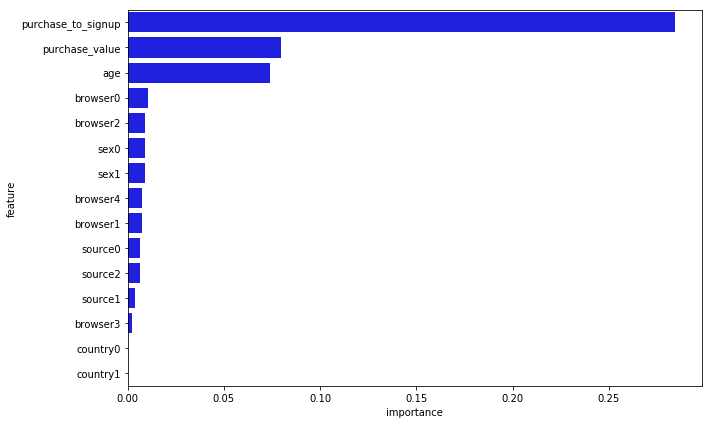

In [55]:
# Extract the feature importances and zip it with the columns into a dataframe# Extrac 
importances = rf.feature_importances_[:15]
features = pd.DataFrame({'feature': X.columns[:15], 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=features['importance'], y=features['feature'], color='blue', orient='h')
plt.tight_layout()

In [56]:
# Predit the test data
predicted_proba_test = rf.predict_proba(X_test)[:, -1]
predicted_test = rf.predict(X_test)

print ('Score:     {}'.format(roc_auc_score(y_test, predicted_proba_test)))
print ('Score:     {}'.format(roc_auc_score(y_test, predicted_test)))

Score:     0.7641433767433524
Score:     0.7646523075796948


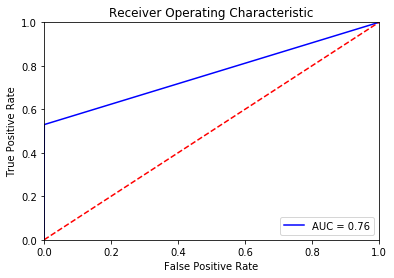

In [57]:
# Plot the ROC Curve
fpr, tpr, threshold = roc_curve(y_test, predicted_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

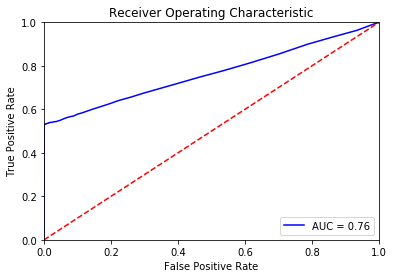

In [58]:
# Plot the ROC Curve
fpr, tpr, threshold = roc_curve(y_test, predicted_proba_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [59]:
# Predict the full fraud rate
predicted_churn_rate = predicted_test.sum() / len(predicted_test)

# print the final result
print ('Predicted Fraud Rate: {:.2f}%'.format(predicted_churn_rate * 100))
print ('Actual Fraud Rate: {:.2f}%'.format(np.mean(y_test) * 100))

Predicted Fraud Rate: 5.15%
Actual Fraud Rate: 9.60%


## Conclusion:
It appears that the model underestimates the fraud rate. This suggests the occurrence of false positives in the classification. However, because the model has an auc score of ~0.765, the model is acceptable in a real world problem. The model is unable to correctly isolate all fradulent activity, but it appears to get approximately half.
- Most fraudulent activity occurs at the beginning of the year (likely some sort of promotional event to increase customer activity). 
- Fraudulent activity is most often performed by users that create their accounts immediately prior to their purchases (bot activity?). 
- Individuals of ages 31-35 have a higher risk factor for fraud.

### Future Actions:
- Spread promotional events throughout the year, instead of only at the beginning of the year
- If there are no promotional events, the program/site could have issues at that time during the year allowing more fraudulent activity to bypass the security.
- Enforce a waiting interval of (24-48hrs) between the time of signup and time of purchase. This could slow down the traffic of bots.
- If user is identified to be high risk fraudulent, take additional steps to verify the user is real.
- If there is very high risk for a particular user (>85%), have a real individual review the activity.

### Future Direction: (given more time)
- Derive variables to address duplicate device_ids and ip_addresses. Sharing of device_id and ip_address across multiple user_ids can indicate fraudulent activity.
- Execute techniques to address imbalanced classification problems.